# Context
This notebook drives the training process for different models.

# Score analysis

In [105]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [106]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup

In [107]:
scores_path = os.path.join(sup.SCORES_ROOT, "specified", sup.TRAIN_KNN_CODE, "PREPanalysis.csv")

top_barrier=2

## Helper functions

In [108]:
import math

def significance(row, score_col):
  C = int(row["num_classes"])
  score = row[score_col]

  k = 2 if score_col == 'top2accuracy' else 1
  if C == k:
    return 0
  
  # Chance the true class appears in a random top-k set:
  # Choose (k - 1) other classes from the remaining (C - 1), then divide by all
  # possible top-k sets
  # chance_score = math.comb(C - 1, k - 1)  /  math.comb(C, k)
  #       "      = ((C-1)! / ((C-1-(k-1))! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / ((C-k)! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / (k-1)!)  /  (C! / k!)
  #       "      = ((C-1)! / C!)  /  ((k-1)! / k!)
  #       "      = (k! / (k-1)!) / (C! / (C-1)!)
  #       "      = k / C
  # So:
  chance_score = k / C

  if score_col == 'accuracy' or score_col == 'top2accuracy':
    std = math.sqrt(chance_score * (1 - chance_score) / 100 * C)
  elif score_col == 'macro_recall':
    std = math.sqrt((1 - chance_score) / (100 * C**2))
  elif score_col == 'macro_precision':
    std = math.sqrt((C - 1) / (100 * C**2))

  z = (score - chance_score)/std

  return z

def harmonic_z(row, recall_col='macro_recall_z', precision_col='macro_precision_z'):
    recall_z = row[recall_col]
    precision_z = row[precision_col]

    # Handle zero or undefined cases
    if recall_z + precision_z == 0:
        return 0  # or np.nan if you want to mark it

    return 2 * recall_z * precision_z / (recall_z + precision_z)
                

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize(df, group_cols, top, sortby='accuracy', filter_cols=None, filter_values=None):
    """
    Optionally filters df by filter_cols == filter_values, groups by group_cols,
    selects top `top` rows by selected sortby metric, computes mean metric, and plots the result.
    """
    filter_desc = ""

    # Filter if needed
    if filter_cols and filter_values:
        for col, val in zip(filter_cols, filter_values):
            df = df[df[col] == val]
        filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

    # Group, take top `top` by selected sortby metric, compute mean
    mean_scores = (
        df.groupby(group_cols)
          .apply(lambda g: g.sort_values(sortby, ascending=False).head(top)[sortby].mean())
          .reset_index(name=f'mean_{sortby}')
    )

    # Create simple string labels for the x-axis
    mean_scores['label'] = mean_scores[group_cols].astype(str).agg(' | '.join, axis=1)

    # Plot
    colors = sns.color_palette("muted", len(mean_scores))
    plt.figure(figsize=(10, 6))
    plt.bar(mean_scores['label'], mean_scores[f'mean_{sortby}'], color=colors)

    plt.ylabel(f"Mean {sortby} (Top {top})")
    plt.title(f"Top {top} Mean {sortby} per {' + '.join(group_cols)}{filter_desc}")
    plt.xticks(rotation=45, ha='right')

    # Set y-limits with padding
    min_val = mean_scores[f'mean_{sortby}'].min()
    max_val = mean_scores[f'mean_{sortby}'].max()
    padding = (max_val - min_val) * 0.3  # 10% padding
    #plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

    # Add values on bars
    for i, val in enumerate(mean_scores[f'mean_{sortby}']):
        plt.text(i, val + padding*0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=6)

    plt.tight_layout()
    plt.show()


## Data

In [110]:
import pandas as pd

In [111]:
knn_scores_df = pd.read_csv(scores_path)
knn_scores_df.sort_values(by="top2accuracy", ascending=False)

,data_unit,PH2,num_classes,difficulty,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall
0,Spf,False,2,easy,0.987448,1.000000,0.987426,0.987272,0.987614
84,Spf,True,2,easy,0.981172,1.000000,0.981153,0.980921,0.981807
254,Spv,True,2,hard,0.767442,1.000000,0.766304,0.769737,0.766234
253,Spv,True,2,average,0.906977,1.000000,0.894089,0.882143,0.911538
252,Spv,True,2,easy,0.925000,1.000000,0.923810,0.927110,0.921717
...,...,...,...,...,...,...,...,...,...
241,Spv,False,26,average,0.636197,0.065814,0.641891,0.667483,0.641217
324,Spv,True,26,easy,0.405714,0.064762,0.418028,0.456095,0.410708
240,Spv,False,26,easy,0.603810,0.064762,0.608419,0.626063,0.610826
228,Spv,False,22,easy,0.641723,0.063492,0.641022,0.659291,0.646527


In [112]:
for metric_name in ['accuracy', 'top2accuracy', 'macro_precision', 'macro_recall']:
  knn_scores_df[f'{metric_name}_z'] = knn_scores_df.apply(lambda x: significance(x, metric_name), axis=1)

knn_scores_df['harmonic_z'] = knn_scores_df.apply(harmonic_z, axis=1)

knn_scores_df

,data_unit,PH2,num_classes,difficulty,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall,accuracy_z,top2accuracy_z,macro_precision_z,macro_recall_z,harmonic_z
0,Spf,False,2,easy,0.987448,1.000000,0.987426,0.987272,0.987614,6.893551,0.000000,9.745442,13.791808,11.420813
1,Spf,False,2,average,0.996094,1.000000,0.996093,0.996169,0.996047,7.015825,0.000000,9.923372,14.030340,11.624777
2,Spf,False,2,hard,0.974806,1.000000,0.974737,0.974346,0.975312,6.714774,0.000000,9.486929,13.443859,11.123990
3,Spf,False,3,easy,0.997406,0.662776,0.997416,0.997455,0.997391,8.133196,-0.047655,14.088158,24.399027,17.862431
4,Spf,False,3,average,0.997354,0.693122,0.997256,0.997256,0.997256,8.132565,0.324007,14.083927,24.394077,17.857704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Spv,True,28,average,0.468310,0.077465,0.470658,0.511239,0.476555,4.405338,0.044294,25.624118,125.700496,42.570263
332,Spv,True,28,hard,0.468310,0.077465,0.470658,0.511239,0.476555,4.405338,0.044294,25.624118,125.700496,42.570263
333,Spv,True,29,easy,0.476271,0.071186,0.471978,0.482082,0.475567,4.496083,0.016276,24.530602,130.178579,41.282087
334,Spv,True,29,average,0.476271,0.071186,0.471978,0.482082,0.475567,4.496083,0.016276,24.530602,130.178579,41.282087


### Inital number-of-classes-agnostic analysis

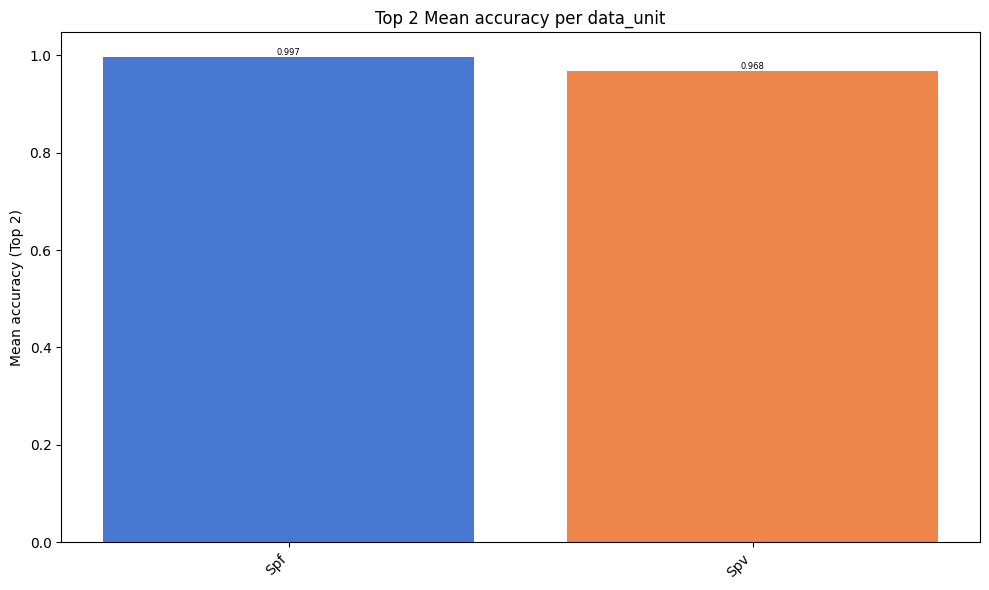

In [113]:
visualize(knn_scores_df, group_cols=['data_unit'], top=top_barrier)

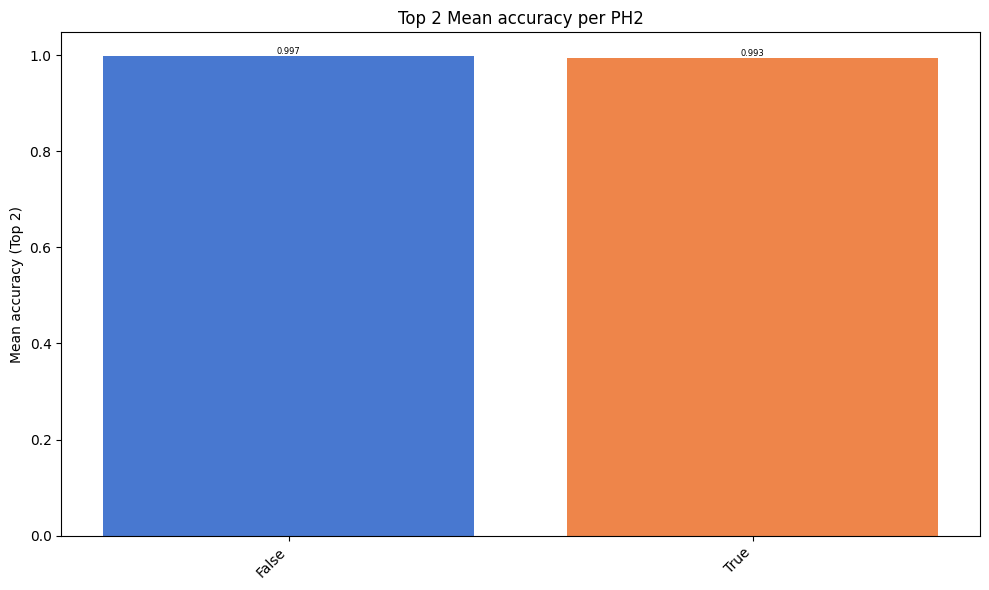

In [114]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier)

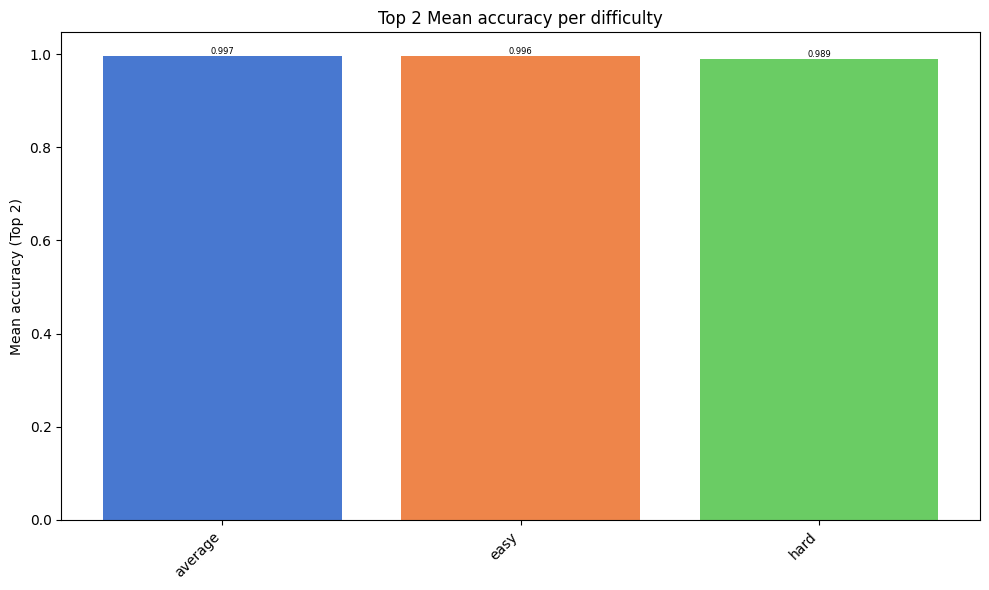

In [115]:
visualize(knn_scores_df, group_cols=['difficulty'], top=top_barrier, sortby='accuracy')

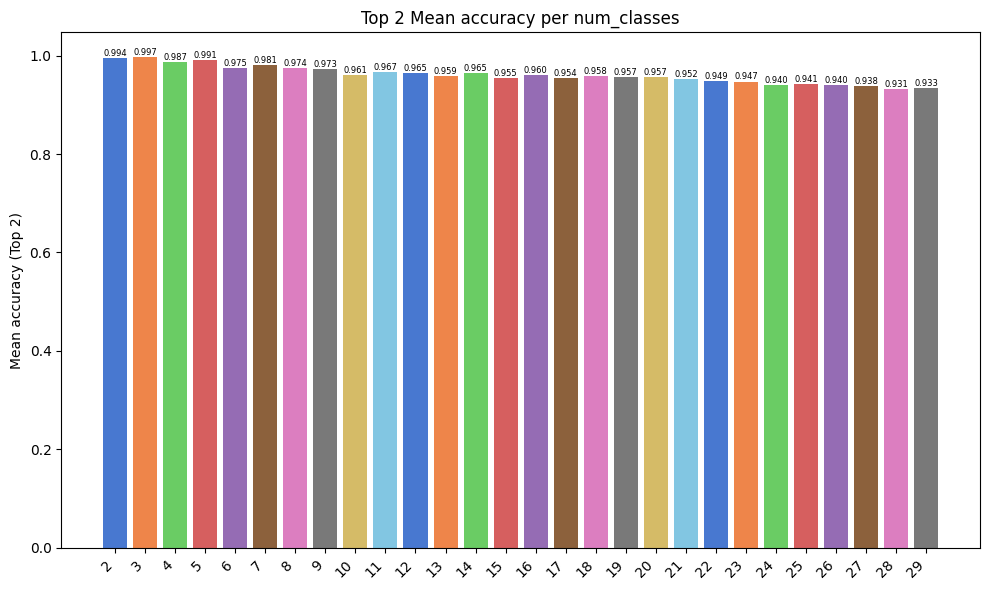

In [116]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier)

### Intial analysis compensanting for number of classes

#### data_unit

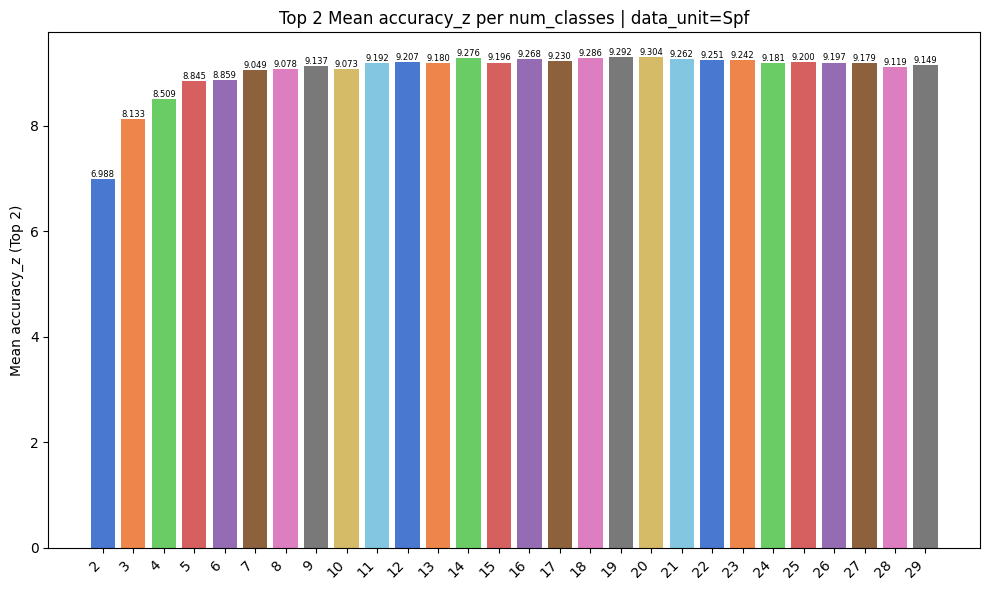

In [117]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF], sortby='accuracy_z')

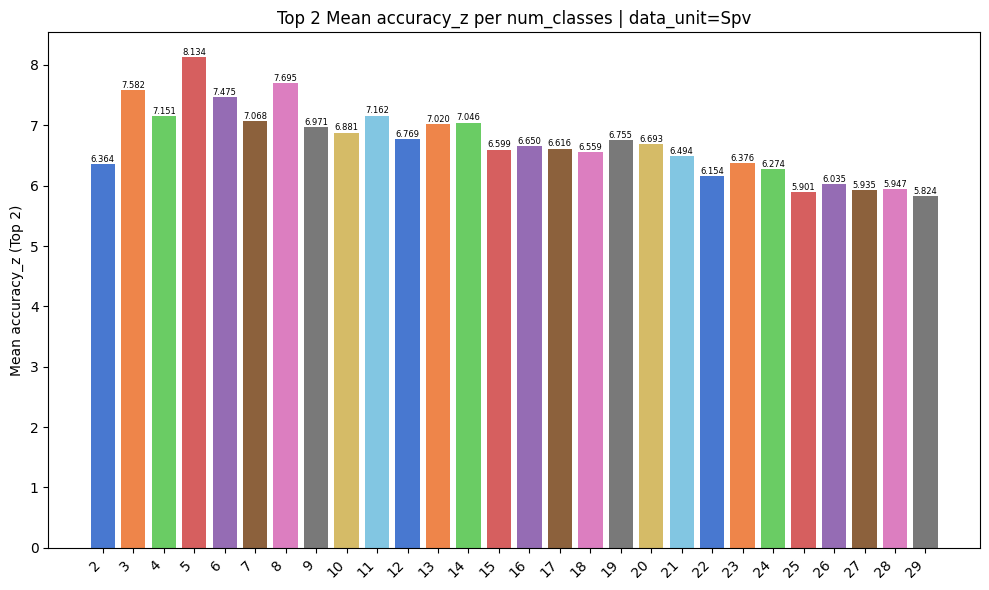

In [118]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV], sortby='accuracy_z')

#### PH2

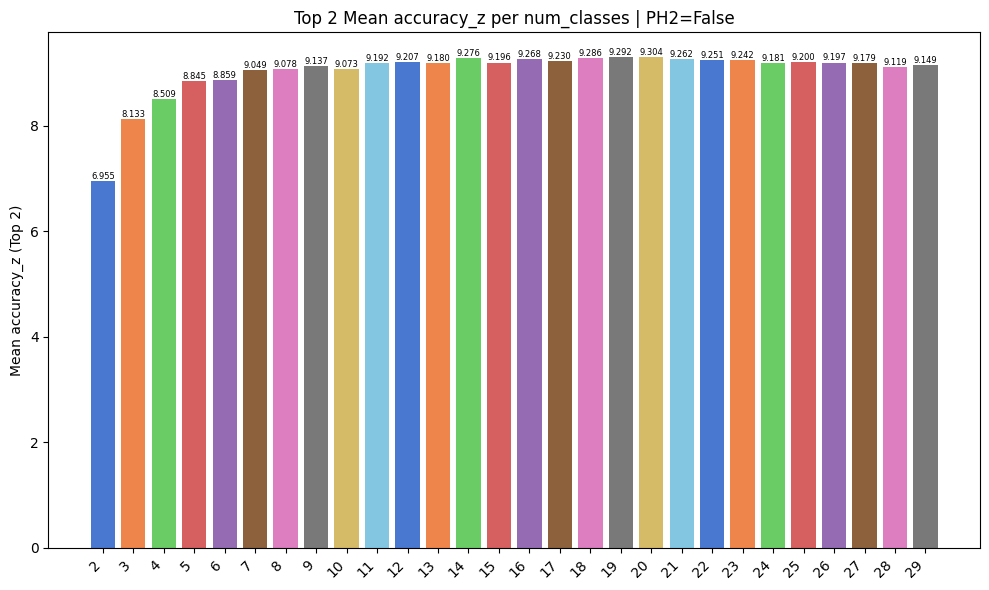

In [119]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[False], sortby='accuracy_z')

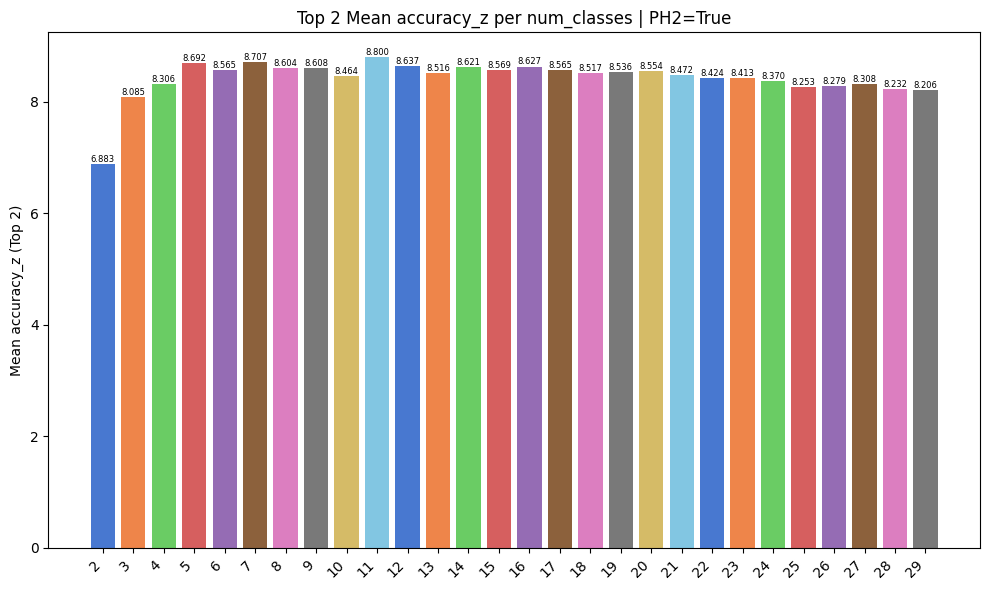

In [120]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[True], sortby='accuracy_z')

#### difficulty

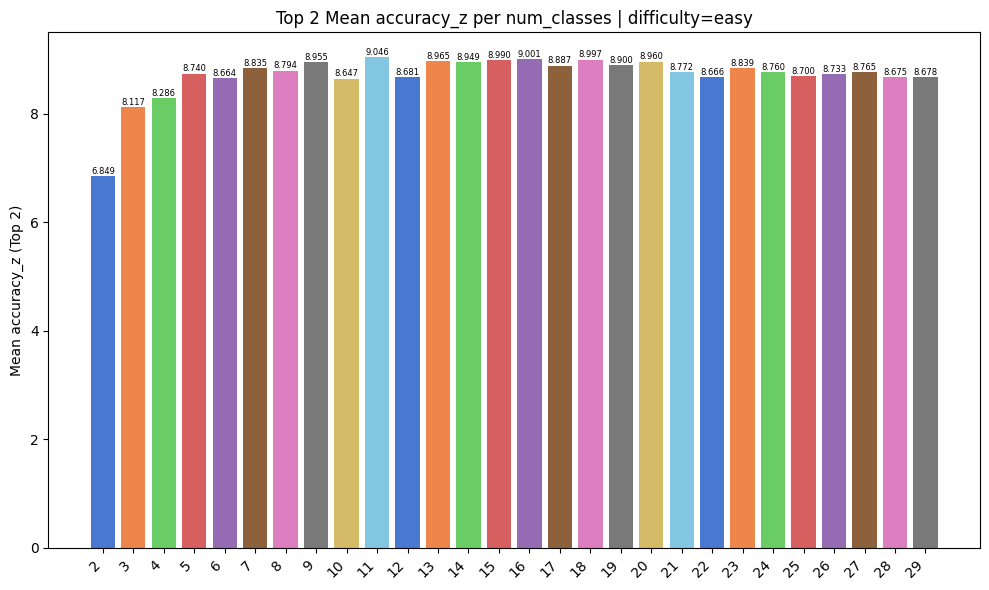

In [121]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['easy'], sortby='accuracy_z')

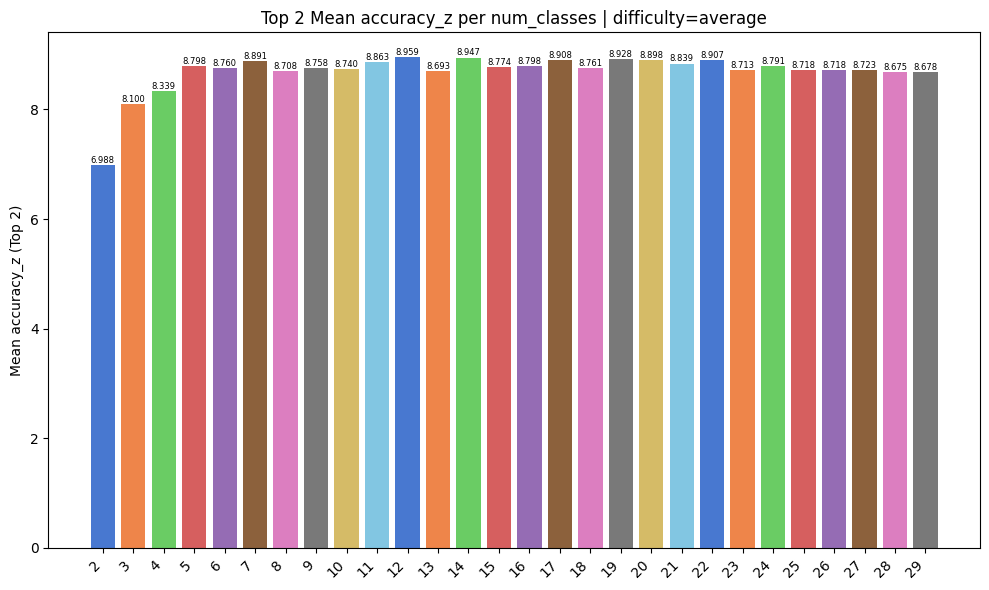

In [122]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['average'], sortby='accuracy_z')

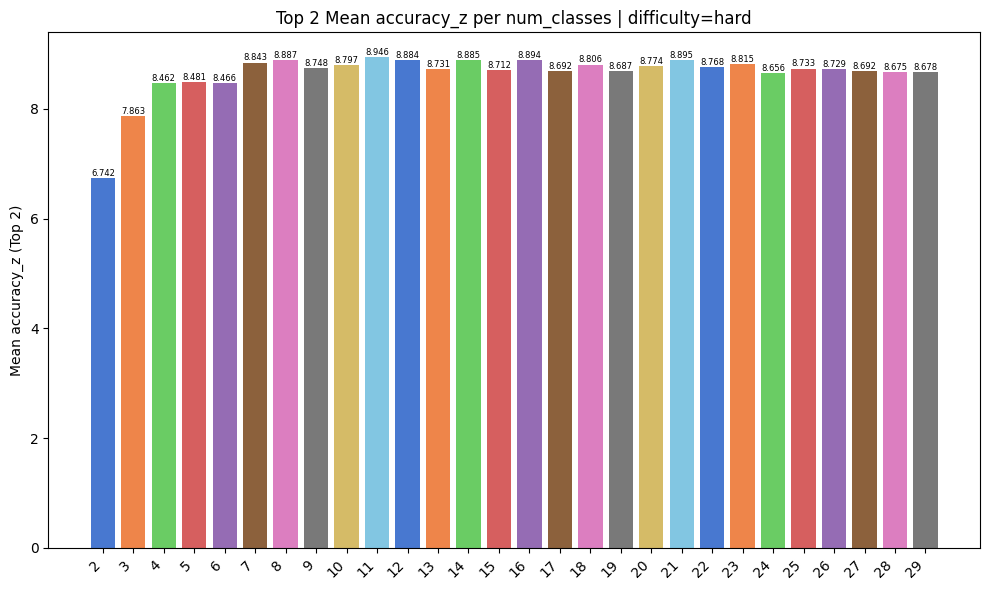

In [123]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['hard'], sortby='accuracy_z')

### Same but with harmonization of significance or recall and precision

#### data_unit

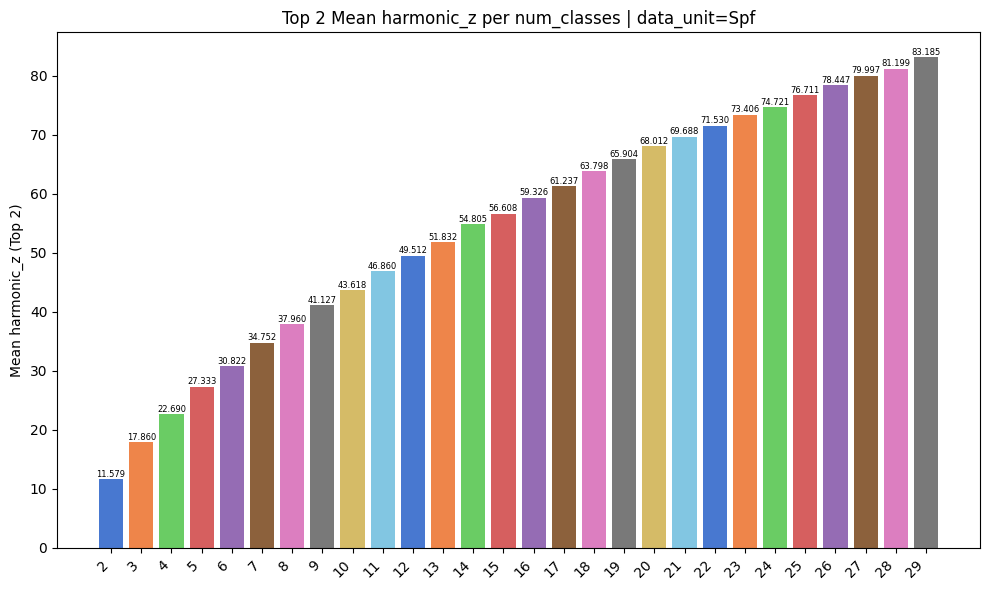

In [124]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF], sortby='harmonic_z')

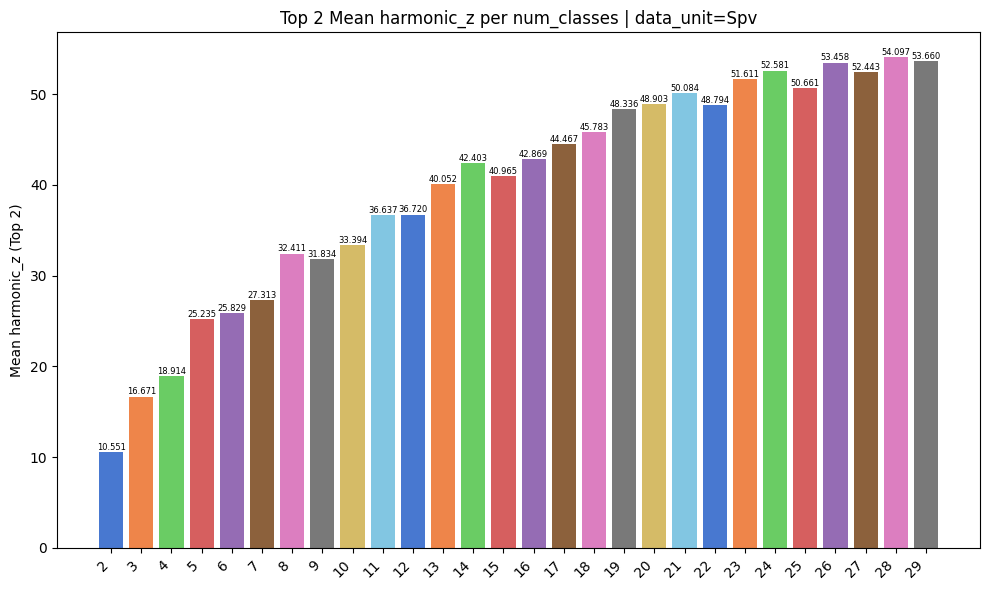

In [125]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV], sortby='harmonic_z')

#### PH2

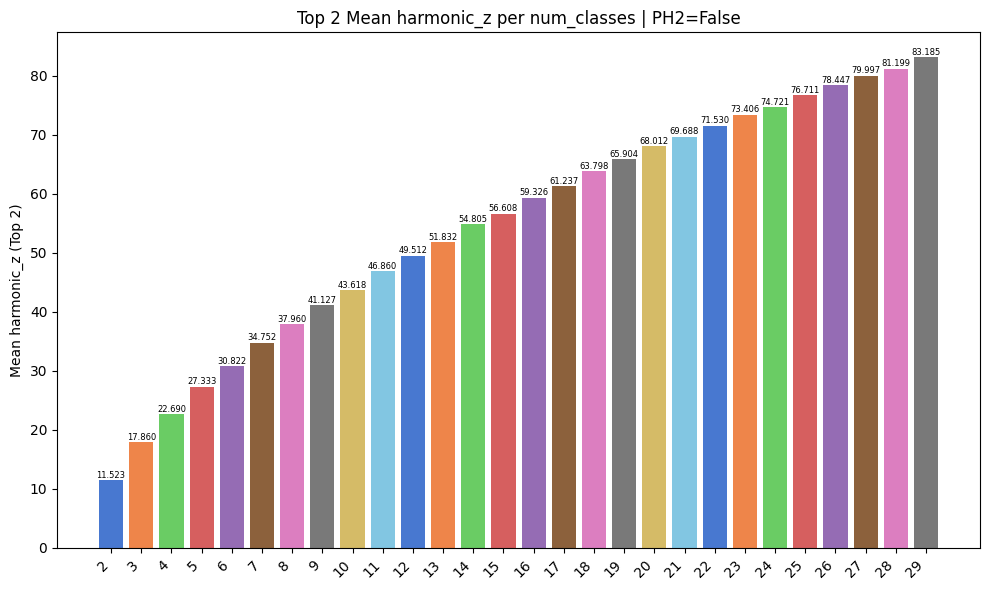

In [126]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[False], sortby='harmonic_z')

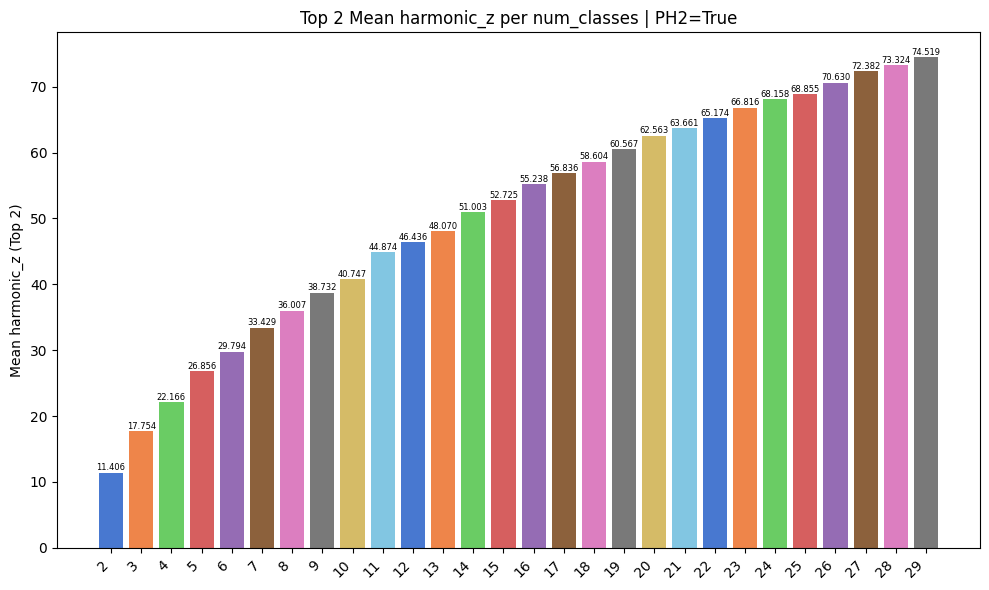

In [127]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[True], sortby='harmonic_z')

#### difficulty

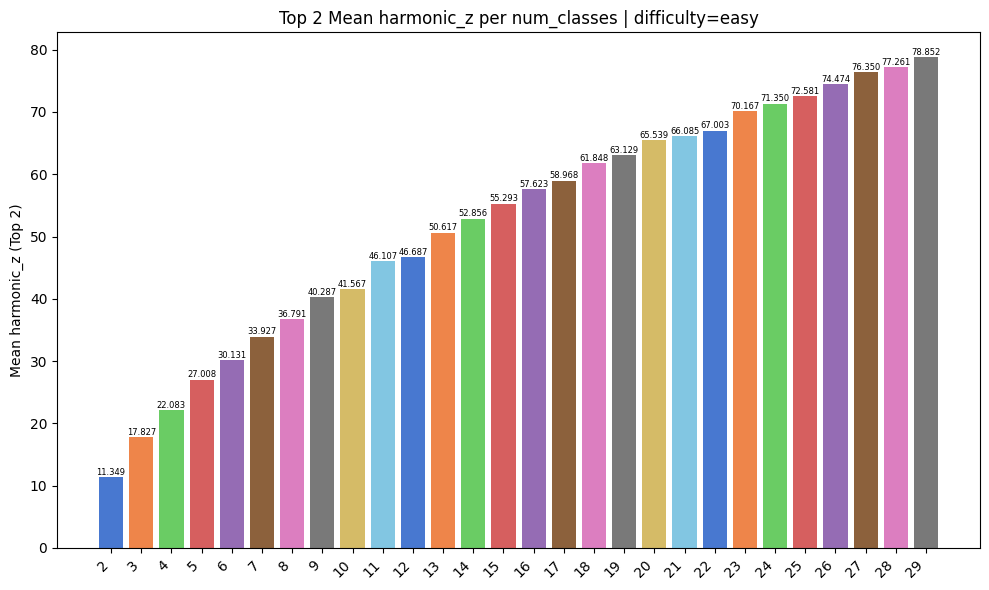

In [128]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['easy'], sortby='harmonic_z')

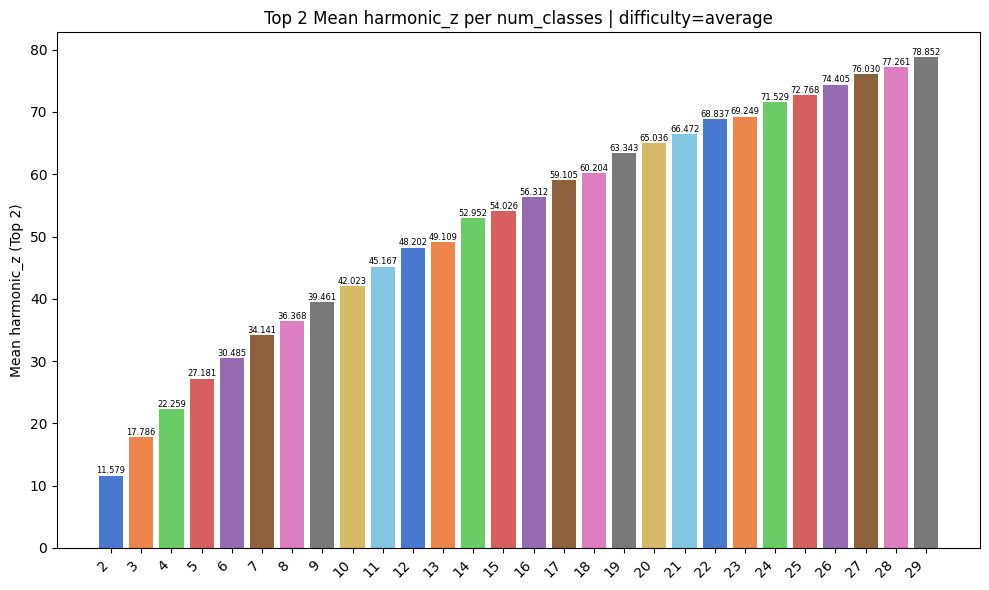

In [129]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['average'], sortby='harmonic_z')

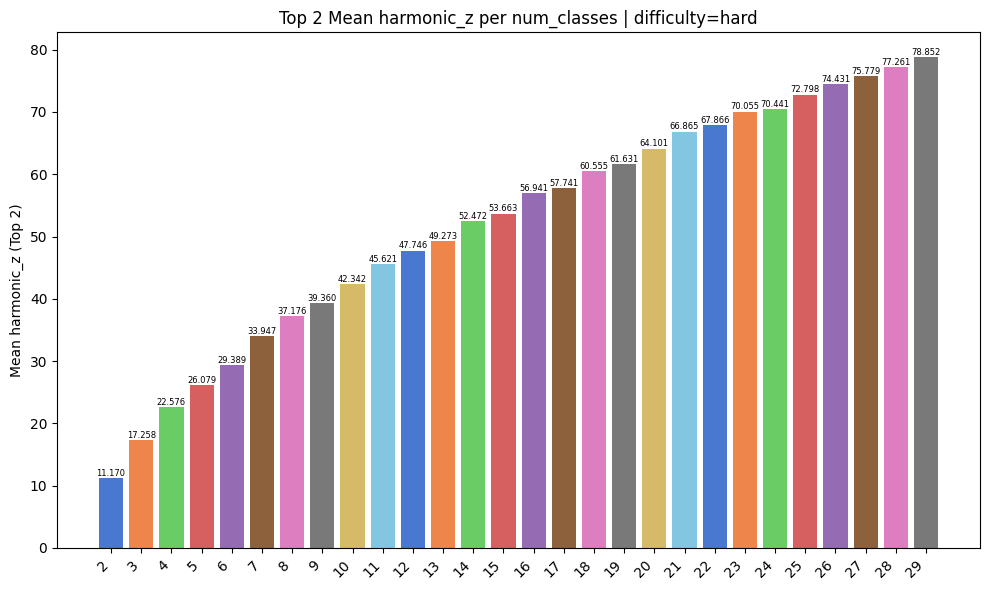

In [130]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['hard'], sortby='harmonic_z')